# Generate embeddings to get the main topic

In this section, we see:
- how to extract the embeddings from one idea.
- Reduce the dimensionality of the embeddings to visualize the relative positions of idea.
- Create clusters from closed embeddings to propose the main topics.
- discuss the limit of one such approach and the perspective.

## Extract the embeddings with STS LLM model

First, download from HuggingFace Hub one similarity sentence model. This kind of model are trained to keep closed in the embedding space the sentences that are similar in meaning. For example, "I love you" and "I adore you" are similar sentences. The model will output a vector for each sentence, and the closer the vectors are, the more similar the sentences are.

We're manipulating french sentences. We can try two different model:
- [LaBSE]()
- [intfloat/multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct)

The e5 model seems to be better according to [HuggingFace MBET leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

In [1]:
from sentence_transformers import SentenceTransformer

MODEL_NAME = "sentence-transformers/LaBSE"
model = SentenceTransformer(MODEL_NAME)

/home/machine_learning/projects/perspectiva/prisma-logic/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
items = [
    "Il faut nourrir le chat.",
    "Le chien de garde est devant la maison.",
    "Les mathématiques sont ma passion.",
    "La physique c'est pour ceux qui sont nuls en maths."]
embeddings = model.encode(items)
print(embeddings.shape)

(4, 768)


In [3]:
from umap import UMAP

reducer = UMAP(n_neighbors=2, n_components=2, metric='cosine')
reducer.fit(embeddings)
emb2d = reducer.transform(embeddings)
print(emb2d.shape)

/home/machine_learning/projects/perspectiva/prisma-logic/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(4, 2)


/home/machine_learning/projects/perspectiva/prisma-logic/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


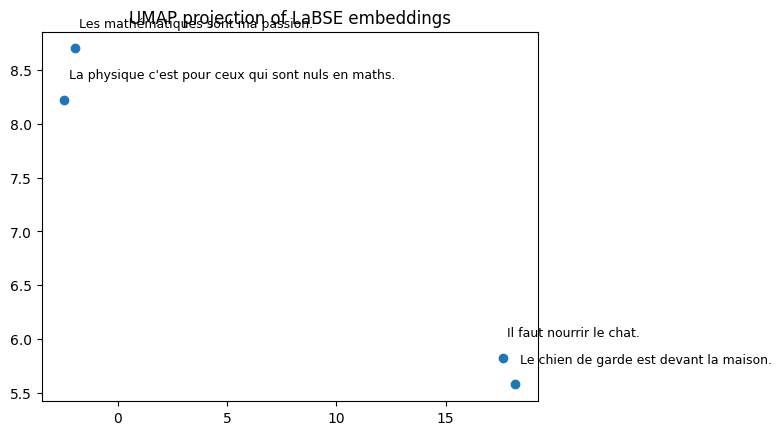

In [4]:
import matplotlib.pyplot as plt

plt.scatter(emb2d[:, 0], emb2d[:, 1])
plt.title("UMAP projection of LaBSE embeddings")

for i, item in enumerate(items):
    plt.text(emb2d[i, 0] + 0.2, emb2d[i, 1] + 0.2, item, fontsize=9)
    
plt.show()

**Observations:**
- the closed embeddings seems to be closed in meaning in the 2D space.

It is the expected behavior as the LaBSE model, and the Sentence Similarity model, are trained to produce embeddings that are close in the vector space for similar sentences.
The challenge is just to train the model to the corpus of text that corresponding to our field. For instance, French about daily subject.

## Visualize and cluster the embeddings of thousand item : the challenge

See below the result of the LLM extractions of the [contributions of the n°163 question of the Grand Débat National 2019](https://huggingface.co/datasets/perspectiva-solution/embeddings-gdn-question-163). Each extraction is related to the contribution Id. The orginal contribution can be found in [Perspectiva HuggingFace Hub](https://huggingface.co/datasets/perspectiva-solution/contributions-gdn-question-163).

The dataset contains:
- the items by contribution Id
- the embeddings in 1024 dimension
- the UMAP reduced embedding in 20 dimension to cluster
- the UMAP reduced embedding in 2 dimension to plot
- the current proposed cluster Id.
- the title of the cluster

The value `-1` for cluster Id means the idea is related to no cluster. The embedding is too fare or too isolated from neighbors to be part of one cluster.

Regarding the methodology, the title of the cluster what generated by LLM. Around 20 to 100 items are taken from one cluster, and we ask one LLM to make one title. The items are selected to be representative of the diversity of the cluster (and not the mean or the centroid).
We does not describe the script as it is quite straightforward.

### The 2D scatter plot is not enough to understand the relative importance of the main items.

In [5]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("perspectiva-solution/embeddings-gdn-question-163")['train']

In [6]:
ds[0]

{'contribution_id': 39494,
 'text': 'arrêter de préférer les classes moyennes à la dépense des riches et des bénéficiaires du système',
 'embeddings_1024': [-0.24221692979335785,
  -0.5539478063583374,
  -0.42729660868644714,
  -0.7129496932029724,
  0.01377530861645937,
  0.17497481405735016,
  0.051590561866760254,
  0.10872132331132889,
  0.13213038444519043,
  -0.10053029656410217,
  0.26859843730926514,
  0.26942598819732666,
  -0.18908816576004028,
  -0.19428260624408722,
  -0.34493887424468994,
  -0.3137947618961334,
  0.034439817070961,
  -0.17854736745357513,
  0.1654207855463028,
  0.0932399332523346,
  -0.16515523195266724,
  -0.7113691568374634,
  0.20178963243961334,
  -0.19099177420139313,
  -0.1614750474691391,
  -0.4192849099636078,
  -0.1285392940044403,
  0.15004846453666687,
  -0.41795614361763,
  0.2844484746456146,
  0.20360925793647766,
  0.06876041740179062,
  -0.25631093978881836,
  0.11571101099252701,
  -0.17549291253089905,
  -0.034396424889564514,
  -0.35738

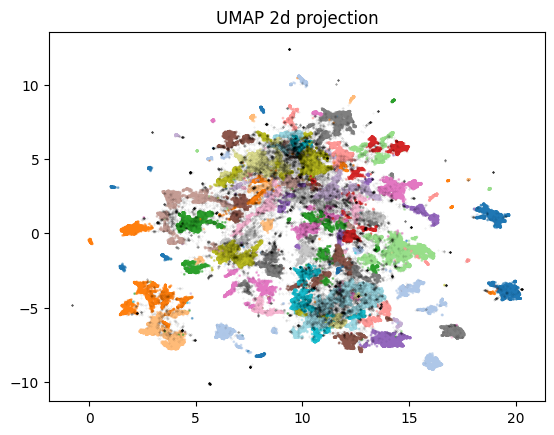

In [13]:
import numpy as np

ds_cluster = ds.filter(lambda x: x != -1, input_columns=['cluster_id'])
ds_wo_cluster = ds.filter(lambda x: x == -1, input_columns=['cluster_id'])

colors = np.array(ds_cluster["cluster_id"]).astype(float)
colors /= colors.max()

arr_cluster = np.array(ds_cluster["umap_2"])
arr_wo_cluster = np.array(ds_wo_cluster["umap_2"])

cmap = plt.get_cmap("tab20")
plt.scatter(*arr_cluster.T, s=1, c=colors, cmap=cmap, alpha=0.5)
plt.scatter(*arr_wo_cluster.T, s=0.1, color="black", alpha=0.1)
plt.title("UMAP 2d projection")
plt.show()

**Observations:**
- When we look at the embedding of many items, we can see some clusters, but it is clearly not clear how much the density of the clusters is.
- In fact, one very concentrated cluster is less visible than one cluster that spread a little. The perception give more importance to the surface.

### Current way to communicate: two plots difficult to associate.

In [8]:
from pandas import DataFrame

In [9]:
cluster = np.array(ds_cluster["cluster_id"])
text = np.array(ds_cluster["text"])
title = np.array(ds_cluster["cluster_title"])
arr_cluster = np.array(ds_cluster["umap_2"])
sort_index = np.argsort(cluster)

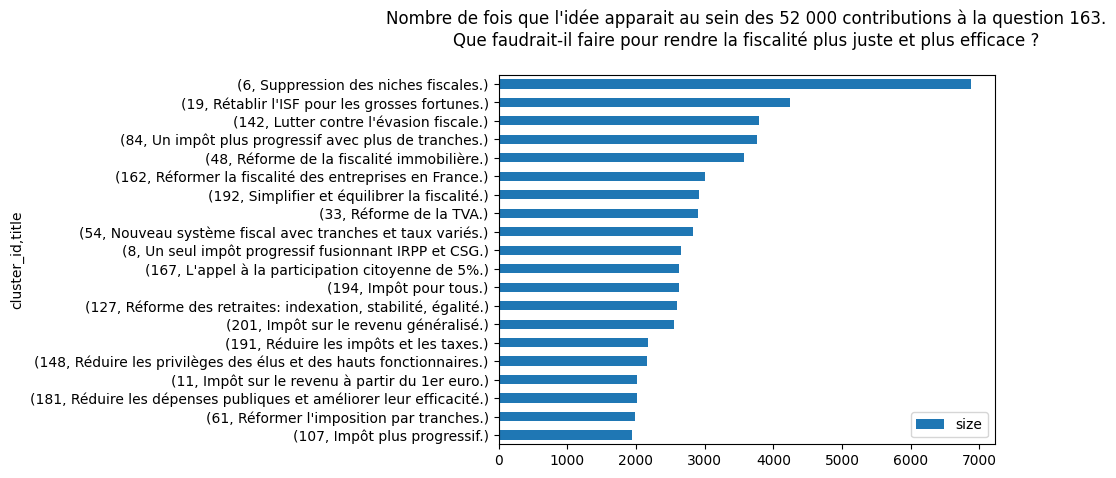

In [12]:
cluster_title_map = {k: v for k, v in zip(cluster, title)}
cluster_size_map = {k: size for k, size in zip(*np.unique(cluster, return_counts=True))}

df = DataFrame([cluster_title_map, cluster_size_map], index=["title", "size"]).T
df.index.name = "cluster_id"


(
    df.reset_index().sort_values(by="size", ascending=True)
    .tail(20)
    .set_index(["cluster_id", "title"])
    .plot.barh()
)
plt.title(
    "Nombre de fois que l'idée apparait au sein des 52 000 contributions à la question 163.\nQue faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?\n"
)

plt.show()

In [11]:
# Commented because to heavy to be push on Github.
# import plotly.express as px

# fig = px.scatter(
#     x=arr_cluster[sort_index, 0],
#     y=arr_cluster[sort_index, 1],
#     color=cluster[sort_index].astype(str),
#     hover_data={"idea": text[sort_index], "cluster": title[sort_index]},
#     color_discrete_sequence=px.colors.qualitative.Alphabet,
# )

# fig.show()